# CNN from scratch

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt #to show img
from tensorflow.keras.datasets import mnist #dataset
from tqdm import tqdm  # Import tqdm for progress bar

## Functions

In [2]:
def add_padding(input_matrix, padding):
    if padding > 0:
        padded_matrix = np.pad(input_matrix, pad_width=padding, mode='constant', constant_values=0)
        return padded_matrix
    else:
        return input_matrix


In [3]:
def convolution(input_matrix, kernel, stride=1, padding=0):
    input_matrix = add_padding(input_matrix, padding)
    input_height, input_width = input_matrix.shape
    kernel_height, kernel_width = kernel.shape

    output_height = int((input_height - kernel_height) / stride) + 1
    output_width = int((input_width - kernel_width) / stride) + 1

    feature_map = np.zeros((output_height, output_width))

    for i in range(0, output_height):
        for j in range(0, output_width):
            start_i = i * stride
            start_j = j * stride
            end_i = start_i + kernel_height
            end_j = start_j + kernel_width

            feature_map[i, j] = np.sum(input_matrix[start_i:end_i, start_j:end_j] * kernel)

    return feature_map

In [4]:
def relu(feature_map):
    activated_map = np.maximum(0, feature_map)
    return activated_map

In [5]:
def pooling(activated_map, pooling_size=2, stride=2):
    output_height = (activated_map.shape[0] - pooling_size) // stride + 1
    output_width = (activated_map.shape[1] - pooling_size) // stride + 1
    pooled_map = np.zeros((output_height, output_width))

    for i in range(0, output_height):
        for j in range(0, output_width):
            start_i = i * stride
            start_j = j * stride
            end_i = start_i + pooling_size
            end_j = start_j + pooling_size

            window = activated_map[start_i:end_i, start_j:end_j]
            pooled_map[i, j] = np.max(window)

    return pooled_map

In [6]:
def flatten(pooled_map):
    pooled_shape = pooled_map.shape

    total_elements = pooled_shape[0] * pooled_shape[1]

    flattened_vector = np.zeros(total_elements)

    index = 0
    for i in range(pooled_shape[0]):
        for j in range(pooled_shape[1]):
            flattened_vector[index] = pooled_map[i, j]
            index += 1

    return flattened_vector

In [7]:
def fully_connected(flattened_vector, weights, biases):
    return np.dot(weights, flattened_vector) + biases

In [8]:
def softmax(logits):
    exp_values = np.exp(logits - np.max(logits))
    return exp_values / np.sum(exp_values)

In [9]:
def cross_entropy_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-9))

In [10]:
def compute_gradients(flattened_output, y_true, logits, weights):
    m = y_true.shape[0]
    y_pred = softmax(logits)
    dL_dz = y_pred - y_true
    dL_dw = np.dot(dL_dz.reshape(-1, 1), flattened_output.reshape(1, -1)) / m
    dL_db = dL_dz / m
    dL_dflattened = np.dot(weights.T, dL_dz)
    return dL_dw, dL_db, dL_dflattened

In [11]:
def max_pooling_backward(dL_dpool, activated_map, pooling_size=2, stride=2):
    dL_dmap = np.zeros_like(activated_map)
    output_height, output_width = dL_dpool.shape
    for i in range(output_height):
        for j in range(output_width):
            start_i = i * stride
            start_j = j * stride
            window = activated_map[start_i:start_i + pooling_size, start_j:start_j + pooling_size]
            max_value = np.max(window)
            for m in range(pooling_size):
                for n in range(pooling_size):
                    if window[m, n] == max_value:
                        dL_dmap[start_i + m, start_j + n] = dL_dpool[i, j]
                        break
    return dL_dmap

In [12]:
def conv_backward(dL_dconv, x, kernel, stride=1, padding=0):
    kernel_rotated = np.rot90(kernel, 2)
    h_x, w_x = x.shape
    h_k, w_k = kernel.shape
    h_out, w_out = dL_dconv.shape

    # Pad x and dx
    x_padded = np.pad(x, ((padding, padding), (padding, padding)), mode='constant', constant_values=0)
    dx_padded = np.zeros_like(x_padded)
    dfilter = np.zeros_like(kernel)

    # Compute dfilter
    for i in range(h_out):
        for j in range(w_out):
            start_i = i * stride
            start_j = j * stride
            x_window = x_padded[start_i:start_i + h_k, start_j:start_j + w_k]
            dfilter += dL_dconv[i, j] * x_window

    # Compute dx
    for i in range(h_x + 2 * padding):
        for j in range(w_x + 2 * padding):
            for m in range(h_out):
                for n in range(w_out):
                    i_out = i - m * stride
                    j_out = j - n * stride
                    if 0 <= i_out < h_k and 0 <= j_out < w_k:
                        dx_padded[i, j] += dL_dconv[m, n] * kernel_rotated[i_out, j_out]

    if padding > 0:
        dx = dx_padded[padding:-padding, padding:-padding]
    else:
        dx = dx_padded

    return dx, dfilter

## Training

In [13]:
# Load and normalize data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Convert labels to one-hot encoding
num_classes = 10
y_train_one_hot = np.zeros((y_train.size, num_classes))
y_train_one_hot[np.arange(y_train.size), y_train] = 1

# Initialize parameters
np.random.seed(42)  # For reproducibility
kernel = np.random.randn(3, 3) * 0.01
epochs = 2
learning_rate = 0.01

# Fully connected layer weights and biases
weights = np.random.randn(num_classes, 196) * 0.01
biases = np.zeros(num_classes)

# Training loop with full backward propagation
for epoch in range(epochs):
    total_loss = 0
    correct_predictions = 0
    print(f"Epoch {epoch + 1}/{epochs}:")
    for i in tqdm(range(len(x_train)), desc="Training"):
        test_image = x_train[i]
        if test_image.ndim == 3:
            test_image = np.mean(test_image, axis=-1)
        y_true = y_train_one_hot[i]
        conv_output = convolution(test_image, kernel, stride=1, padding=1)
        # Activation (ReLU)
        relu_output = relu(conv_output)
        # Max Pooling
        pooled_output = pooling(relu_output, pooling_size=2, stride=2)
        # Flatten
        flattened_output = flatten(pooled_output)
        # Fully Connected Layer
        logits = fully_connected(flattened_output, weights, biases)
        # Softmax
        output_probabilities = softmax(logits)
        # Loss
        loss = cross_entropy_loss(y_true, output_probabilities)
        total_loss += loss
        # Prediction
        predicted_label = np.argmax(output_probabilities)
        true_label = np.argmax(y_true)
        if predicted_label == true_label:
            correct_predictions += 1
        # Gradients for fully connected layer
        dL_dw, dL_db, dL_dflattened = compute_gradients(flattened_output, y_true, logits, weights)
        # Reshape gradient to match pooled output shape
        dL_dpool = dL_dflattened.reshape(pooled_output.shape)
        # Backpropagate through max pooling
        dL_drelu = max_pooling_backward(dL_dpool, relu_output, pooling_size=2, stride=2)
        # Backpropagate through ReLU directly
        dL_dconv = dL_drelu.copy()
        dL_dconv[conv_output <= 0] = 0
        # Backpropagate through convolution
        dx, dfilter = conv_backward(dL_dconv, test_image, kernel, stride=1, padding=1)
        weights -= learning_rate * dL_dw
        biases -= learning_rate * dL_db
        kernel -= learning_rate * dfilter

    average_loss = total_loss / len(x_train)
    accuracy = correct_predictions / len(x_train)
    print(f'Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/2:


Training: 100%|██████████| 60000/60000 [2:17:26<00:00,  7.28it/s]


Average Loss: 0.4149, Accuracy: 0.8735
Epoch 2/2:


Training: 100%|██████████| 60000/60000 [2:14:05<00:00,  7.46it/s]

Average Loss: 0.3125, Accuracy: 0.9085


## Testing

Output probabilities: [6.02304814e-02 1.61433925e-10 9.37145076e-01 1.84385776e-05
 1.72390508e-07 3.40384689e-05 3.23415347e-05 4.09386545e-08
 2.52854752e-03 1.08625973e-05]
Predicted class: 2


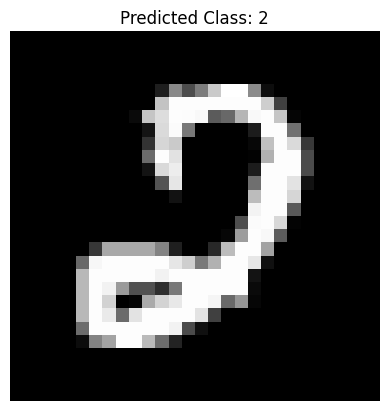

Test Accuracy: 0.9051


In [17]:
# Test the model
test_image = x_test[400]
if test_image.ndim == 3:
    test_image = np.mean(test_image, axis=-1)

# Forward pass for prediction
conv_output = convolution(test_image, kernel, stride=1, padding=1)
relu_output = relu(conv_output)
pooled_output = pooling(relu_output, pooling_size=2, stride=2)
flattened_output = flatten(pooled_output)

# Perform CNN forward pass
logits = fully_connected(flattened_output, weights, biases)
output_probabilities = softmax(logits)

# Print results
predicted_class = np.argmax(output_probabilities)
print("Output probabilities:", output_probabilities)
print("Predicted class:", predicted_class)

# Show the predicted image
plt.imshow(test_image, cmap='gray')
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()

# Accuracy calculation
correct_predictions = 0
for i in range(len(x_test)):
    test_image = x_test[i]
    if test_image.ndim == 3:
        test_image = np.mean(test_image, axis=-1)

    # Forward pass
    conv_output = convolution(test_image, kernel, stride=1, padding=1)
    relu_output = relu(conv_output)
    pooled_output = pooling(relu_output, pooling_size=2, stride=2)
    flattened_output = flatten(pooled_output)

    # Perform CNN forward pass
    logits = fully_connected(flattened_output, weights, biases)
    output_probabilities = softmax(logits)

    # Check if the prediction is correct
    predicted_class = np.argmax(output_probabilities)
    if predicted_class == y_test[i]:
        correct_predictions += 1

accuracy = correct_predictions / len(y_test)
print(f"Test Accuracy: {accuracy:.4f}")